### PCA with SVM Calssifier

In [10]:
import os
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# Sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# function to compute class weights
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

#Matplotlib
import matplotlib.pyplot as plt

# Data management libraries
import scipy.io as scio
import numpy as np

# Visualising Packages
import visualkeras as vk
from PIL import ImageFont

In [4]:
data_train = scio.loadmat('Data/tumor_train_data.mat')
data_val = scio.loadmat('Data/tumor_val_data.mat')
data_test = scio.loadmat('Data/tumor_test_data.mat')

N = 64 # image size (64x64 after preprocessing)
num_classes = 4; # how many different types of classifications we have 

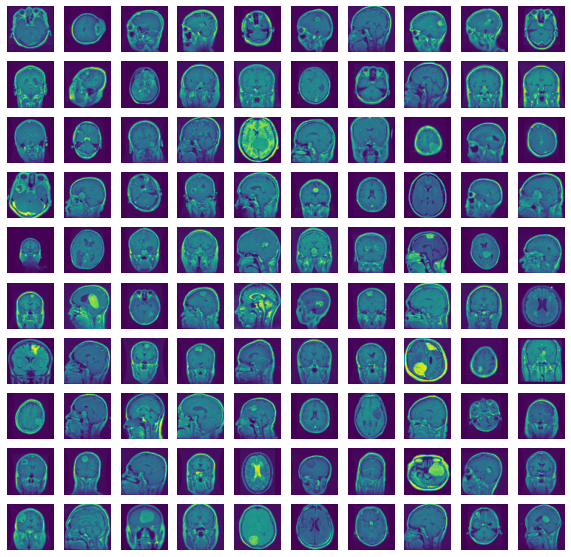

In [25]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(data_train['img_train'][:,:,i])
    ax.axis('off')

In [8]:
train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = data_train['labels_train']
val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
val_y = data_val['labels_val']
test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = data_test['labels_test']

print(train.shape)
print(val.shape)
print(test.shape)

(1958, 64, 64, 1)
(654, 64, 64, 1)
(654, 64, 64, 1)


## Formatting data for PCA

In [9]:
train_PCA = np.reshape(train[:,:,:,:], (1958, -1))
val_PCA = np.reshape(val[:,:,:,:], (654, -1))
test_PCA = np.reshape(test[:,:,:,:], (654, -1))

print(train_PCA.shape)
print(val_PCA.shape)
print(test_PCA.shape)

(1958, 4096)
(654, 4096)
(654, 4096)


## PCA

In [11]:
pca = decomposition.PCA()
pca.fit(train_PCA)

PCA()

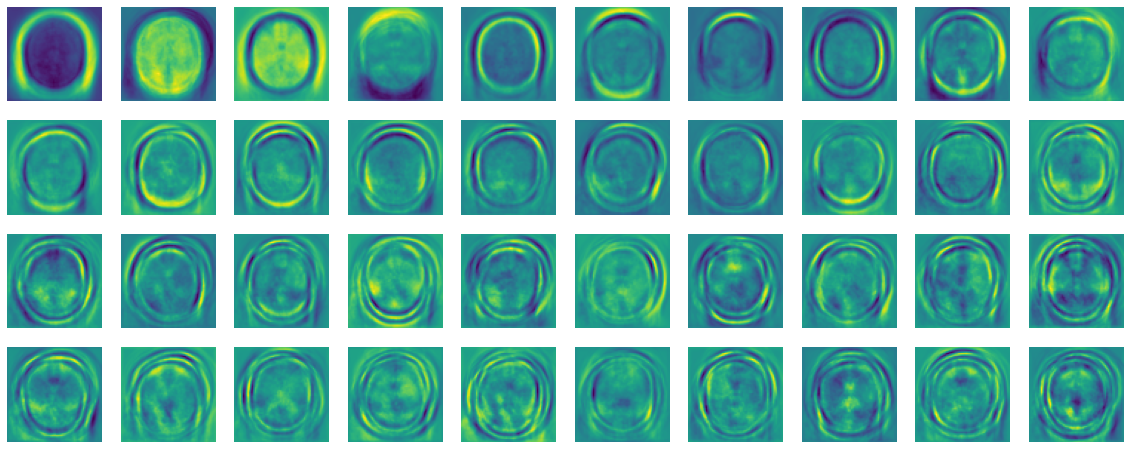

In [12]:
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    pc = np.reshape(pca.components_[i,:], (64, 64)) 
    ax.imshow(pc)
    plt.axis('off')

In [13]:
transformed_train = pca.transform(train_PCA)
transformed_val = pca.transform(val_PCA)
transformed_test = pca.transform(test_PCA)

top90: 270, top95: 454, top99: 938


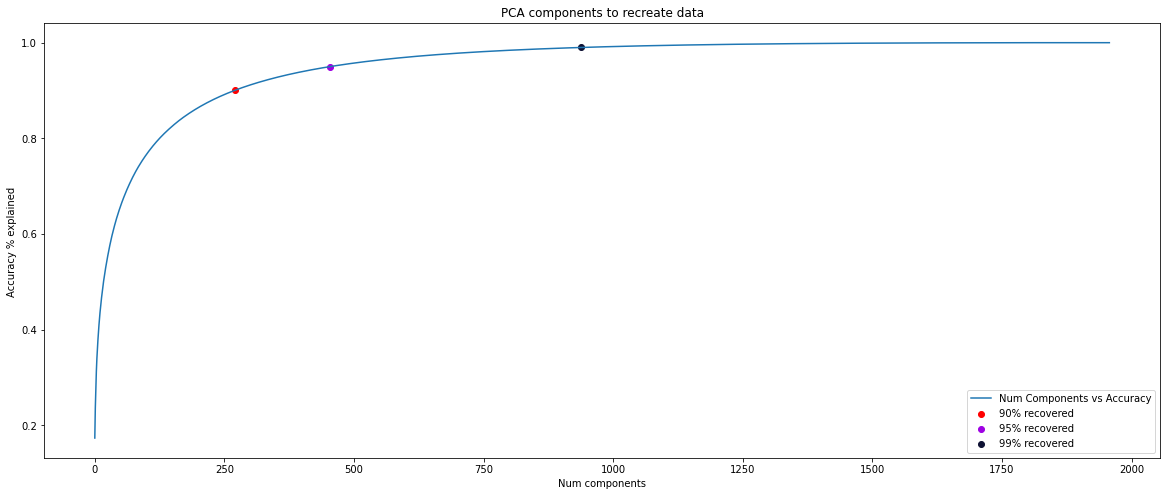

In [20]:
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
top90 = np.where(cumulative_sum > 0.90)[0][0]
top95 = np.where(cumulative_sum > 0.95)[0][0]
top99 = np.where(cumulative_sum > 0.99)[0][0]

fig = plt.figure(figsize=[20, 8])
plt.plot(cumulative_sum)
plt.title('PCA components to recreate data')
plt.xlabel('Num components')
plt.ylabel('Accuracy % explained ')
plt.scatter(top90, cumulative_sum[top90], c='#ff0000')
plt.scatter(top95, cumulative_sum[top95], c='#9e01e3')
plt.scatter(top99, cumulative_sum[top99], c='#0f1234')
plt.legend(["Num Components vs Accuracy", "90% recovered", "95% recovered", "99% recovered"])

print('top90: ' + str(top90) + ',', 'top95: ' + str(top95) + ',', 'top99: ' + str(top99))


(1958, 1958)
(1958, 4096)


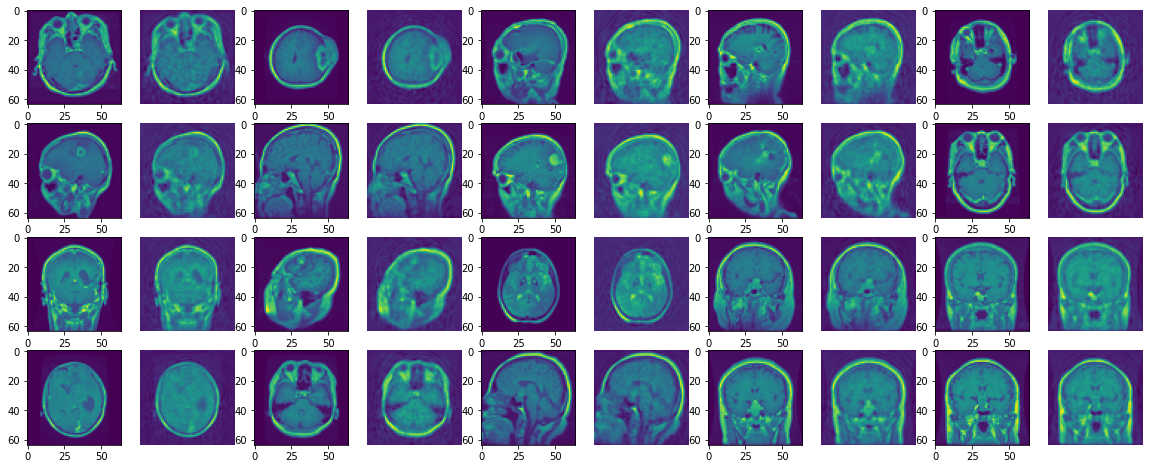

In [23]:
transformed_train_95 = transformed_train
transformed_train_95[:,top95+1:] = 0
print(transformed_train_95.shape)

transform_top95_generate = pca.inverse_transform(transformed_train_95)
print(transform_top95_generate.shape)
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, 2*i + 1)
    ax.imshow(np.reshape(train_PCA[i,:], (64,64)))
    ax = fig.add_subplot(4, 10, 2*i + 2)
    pc = np.reshape(transform_top95_generate[i,:], (64, 64)) 
    ax.imshow(pc)
    plt.axis('off')

In [28]:
# choose to use 95% recreation
transformed_train_95 = transformed_train[:, 0:top95]
transformed_val_95 = transformed_val[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

print(transformed_train_95.shape)
print(train_y.shape)

(1958, 454)
(1958, 1)
